In [8]:
using StatsBase
using TiledIteration
using DelimitedFiles
using IceFloeTracker
using Images

using PyCall
skimage = PyCall.pyimport("skimage")

function shannon_entropy(img)
    # Compute the histogram and normalize
    hist = fit(Histogram, vec(img), 0:255)
    p = hist.weights / sum(hist.weights)

    # Filter out zero probabilities and compute entropy
    p = p[p.>0]
    H = -sum(p .* log2.(p))

    return H
end

function anisotropic_diffusion_3D(I)
    rgbchannels = getrbc_channels(I)

    for i in 1:3
        rgbchannels[:, :, i] .= anisotropic_diffusion_2D(rgbchannels[:, :, i])
    end

return rgbchannels

end

function anisotropic_diffusion_2D(I::AbstractMatrix{T}; gradient_threshold::Union{T,Nothing}=nothing, niter::Int=1) where {T}
    if eltype(I) <: Int
        I = Gray.(I ./ 255)
    end

    # Determine the gradient threshold if not provided
    if gradient_threshold === nothing
        dynamic_range = maximum(I) - minimum(I)
        gradient_threshold = 0.1 * dynamic_range
    end

    # Padding the image (corrected)
    padded_img = padarray(I, Pad(:replicate, (1, 1)))
    dd = sqrt(2)
    diffusion_rate = 1 / 8  # Fixed for maximal connectivity (8 neighbors)

    for _ in 1:niter
        # These are zero-indexed offset arrays
        diff_img_north = padded_img[0:end-1, 1:end-1] .- padded_img[1:end,1:end-1]
        diff_img_east = padded_img[1:end-1, 1:end] .- padded_img[1:end-1, 0:end-1]
        diff_img_nw = padded_img[0:end-2, 0:end-2] .- I
        diff_img_ne = padded_img[0:end-2, 2:end] .- I
        diff_img_sw = padded_img[2:end, 0:end-2] .- I
        diff_img_se = padded_img[2:end, 2:end] .- I

        # Exponential conduction coefficients
        conduct_coeff_north = exp.(-(abs.(diff_img_north) ./ gradient_threshold) .^ 2)
        conduct_coeff_east = exp.(-(abs.(diff_img_east) ./ gradient_threshold) .^ 2)
        conduct_coeff_nw = exp.(-(abs.(diff_img_nw) ./ gradient_threshold) .^ 2)
        conduct_coeff_ne = exp.(-(abs.(diff_img_ne) ./ gradient_threshold) .^ 2)
        conduct_coeff_sw = exp.(-(abs.(diff_img_sw) ./ gradient_threshold) .^ 2)
        conduct_coeff_se = exp.(-(abs.(diff_img_se) ./ gradient_threshold) .^ 2)


        # Flux calculations
        flux_north = conduct_coeff_north .* diff_img_north
        flux_east = conduct_coeff_east .* diff_img_east
        flux_nw = conduct_coeff_nw .* diff_img_nw
        flux_ne = conduct_coeff_ne .* diff_img_ne
        flux_sw = conduct_coeff_sw .* diff_img_sw
        flux_se = conduct_coeff_se .* diff_img_se

        # Back to regular 1-indexed arrays
        flux_north_diff = flux_north[1:end-1, :] .- flux_north[2:end, :]
        flux_east_diff = flux_east[:, 2:end] .- flux_east[:, 1:end-1]

        # Discrete PDE solution
        sum_ = (1 / (dd^2)) .* (flux_nw .+ flux_ne .+ flux_sw .+ flux_se)
        I = I .+ diffusion_rate .* (flux_north_diff .- flux_north_diff .+ sum_)

    end

    return I
end


function imshow(img)
    if typeof(img)<: BitMatrix
        return Gray.(img)
    end
    Gray.(img ./ 255)
end

function to_uint8(img)
    img = UInt8.(round.(img))
    img = clamp.(img, 0, 255)
    return img
end

function adapthisteq(img, nbins=256, clip=0.01)

    # Step 1: Normalize the image to [0, 1] based on its own min and max
    image_min, image_max = minimum(img), maximum(img)
    normalized_image = (img .- image_min) / (image_max - image_min)

    # Step 2: Apply adaptive histogram equalization. equalize_adapthist handles the tiling to 1/8 of the image size (equivalent to 8x8 blocks in MATLAB)
    equalized_image = skimage.exposure.equalize_adapthist(
        normalized_image,
        clip_limit=0.01,  # Equivalent to MATLAB's 'ClipLimit'
        nbins=255         # Number of histogram bins. 255 is used to match the default in MATLAB script
    )

    # Step 3: Rescale the image back to the original range [image_min, image_max]
    final_image = skimage.exposure.rescale_intensity(equalized_image, in_range="image", out_range=(image_min, image_max))

    # Convert back to the original data type if necessary
    final_image = to_uint8(final_image)

    return final_image
end

function getrbc_channels(img)
    redc = red.(img) * 255
    greenc = green.(img) * 255
    bluec = blue.(img) * 255

    return cat(redc, greenc, bluec, dims=3)
end


function getrbc_channels_(img)::Tuple{AbstractMatrix{Int64}, AbstractMatrix{Int64}, AbstractMatrix{Int64}}
    # Extract color channels as vectors
    red_vector = red.(img)
    green_vector = green.(img)
    blue_vector = blue.(img)

    # Convert vectors to matrices if necessary (e.g., assuming square images)
    img_size = size(img)
    redc = reshape(red_vector, img_size) .* 255
    greenc = reshape(green_vector, img_size) .* 255
    bluec = reshape(blue_vector, img_size) .* 255

    # Convert to Int64 if necessary
    redc = Int64.(redc)
    greenc = Int64.(greenc)
    bluec = Int64.(bluec)

    return redc, greenc, bluec
end




getrbc_channels_ (generic function with 1 method)

In [9]:
clouds = readdlm("cloudsref.csv", ',', Int16)

8120×4458 Matrix{Int16}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …    0    0    0    0    0    0    0
 0  0  0  0  0  0  0  0  0  0  0  0  0       0    0    0    0    0    0    0
 0  0  0  0  0  0  0  0  0  0  0  0  0       0    0    0    0    0    0    0
 0  0  0  0  0  0  0  0  0  0  0  0  0       0    0    0    0    0    0    0
 0  0  0  0  0  0  0  0  0  0  0  0  0       0    0    0    0    0    0    0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  183  180    0    0    0    0    0
 0  0  0  0  0  0  0  0  0  0  0  0  0     175  168  169    0    0    0    0
 0  0  0  0  0  0  0  0  0  0  0  0  0     167  160  163    0    0    0    0
 0  0  0  0  0  0  0  0  0  0  0  0  0     163  165    0    0    0    0    0
 0  0  0  0  0  0  0  0  0  0  0  0  0       0    0    0    0    0    0    0
 ⋮              ⋮              ⋮        ⋱                        ⋮       
 0  0  0  0  0  0  0  0  0  0  0  0  0     115  110  103   98  107  122  133
 0  0  0  0  0  0  0  0  0  0  0  0  0     113  113  1

In [12]:
land = (load("c:\\Users\\cpaniagu\\Documents\\ice-floe-tracker-origin\\existing_code\\input\\info\\Land.tif"))

landmask = IceFloeTracker.create_landmask(land)

(dilated = Bool[1 1 … 1 1; 1 1 … 1 1; … ; 0 0 … 1 1; 0 0 … 1 1], non_dilated = Bool[1 1 … 1 1; 1 1 … 1 1; … ; 0 0 … 1 1; 0 0 … 1 1])

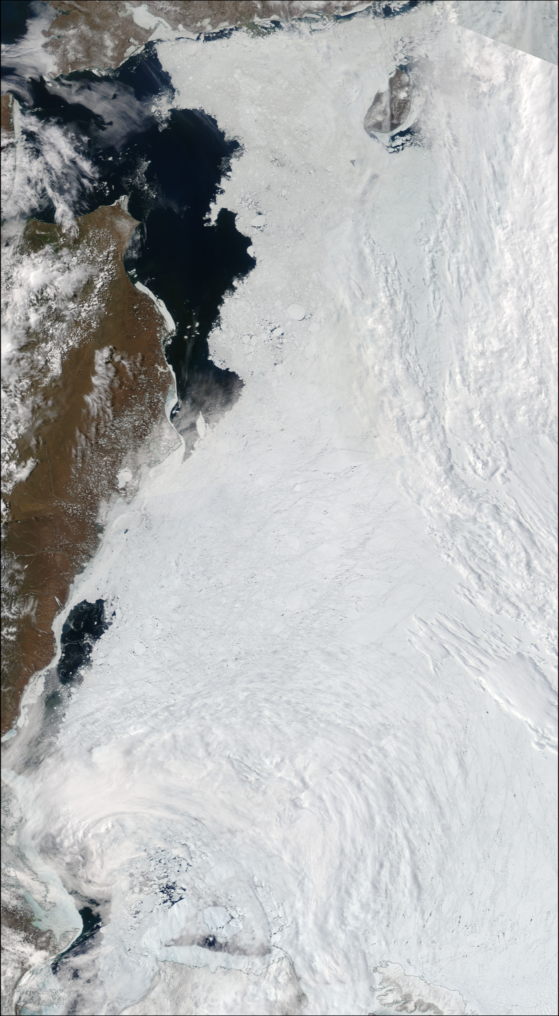

In [13]:
true_color_img = (load("c:\\Users\\cpaniagu\\Documents\\ice-floe-tracker-origin\\existing_code\\input\\images\\NE_Greenland.2020162.aqua.250m.tif"))

In [14]:
IceFloeTracker.apply_landmask!(clouds, landmask.dilated)

In [20]:
# # Access each channel
redc = red.(true_color_img) * 255
greenc = green.(true_color_img) * 255
bluec = blue.(true_color_img) * 255
channels_ = cat(redc, greenc, bluec, dims=3)


8120×4458×3 Array{Float32, 3}:
[:, :, 1] =
  14.0   14.0   14.0   13.0   13.0  …  220.0  223.0  224.0  220.0  213.0
  14.0   14.0   14.0   13.0   13.0     220.0  220.0  218.0  216.0  212.0
  14.0   14.0   14.0   13.0   13.0     221.0  216.0  214.0  216.0  216.0
  14.0   14.0   14.0   13.0   13.0     223.0  218.0  219.0  224.0  224.0
  14.0   14.0   14.0   13.0   13.0     224.0  220.0  223.0  227.0  223.0
  14.0   14.0   14.0   13.0   13.0  …  219.0  220.0  222.0  222.0  213.0
  14.0   14.0   14.0   13.0   13.0     211.0  218.0  219.0  213.0  206.0
  14.0   14.0   14.0   13.0   13.0     205.0  216.0  219.0  209.0  206.0
  13.0   13.0   13.0   13.0   13.0     205.0  208.0  212.0  213.0  212.0
  13.0   13.0   13.0   13.0   13.0     208.0  212.0  214.0  211.0  208.0
   ⋮                                ⋱                  ⋮           
 143.0  142.0  142.0  141.0  143.0     204.0  205.0  207.0  209.0  220.0
 153.0  149.0  143.0  143.0  142.0     212.0  209.0  211.0  219.0  229.0
 153.0  146.0

In [21]:
# TODO: Put this in a function

# Input Images: true color, false color, and landmask

rgbchannels = getrbc_channels(true_color_img)

# 1. Apply diffuse (anisotropic diffusion) to each channel of true color image
aniso_diff_rgb = anisotropic_diffusion_3D(true_color_img)

# 2. Apply landmask to falscolor image
IceFloeTracker.apply_landmask!(clouds, landmask.dilated)

# 3. Split falscolor into tiles; split each channel of true color image into tiles
# traverse tiles
rtile, ctile = size(clouds)
tile_size = (rtile / 8, ctile / 6)

# convert tile_size to Tuple{Int, Int}
tile_size = Tuple{Int, Int}(tile_size)
cloudtiles = TileIterator(axes(clouds),tile_size)
# truecolortiles = TileIterator(axes(clouds),tile_size)


# # 4. For each tile, compute the entropy in the falscolor tile, and the fraction of white and black pixels
for tile in cloudtiles
        entropy = shannon_entropy(clouds[tile...])
        whitefraction = sum(clouds[tile...] .> 25.5) / length(clouds[tile...])

        # 5. If the entropy is above a threshold, and the fraction of white pixels is above a threshold, then apply histogram equalization to the tiles of each channel of the true color image. Otherwise, keep the original tiles.
        if entropy > 4 && whitefraction > 0.4
            for i in 1:3
                rgbchannels[:,:,i][tile...] .= adapthisteq(rgbchannels[:,:,i][tile...])
            end
        end
end
